CS524: Introduction to Optimization Lecture 27
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## November 11, 2025
--------------

In [4]:
import gamspy as gp
import gamspy.math as gpm

import sys
import numpy as np
import pandas as pd

In [5]:
# Kalvelagen, E, Model Building with GAMS. forthcoming

gp.set_options({"USE_PY_VAR_NAME": "yes"})
cont = gp.Container(load_from="qp6.gdx")

# Sets
days, stocks = cont.getSymbols(["days", "stocks"])

# Parameters
returns, val = cont.getSymbols(["return", "val"])

# Set
d = gp.Set(cont,domain=[days], description="selected days")
s = gp.Set(cont,domain=[stocks], description="selected stocks")
t = gp.Alias(cont,alias_with=s)

# select subset of stocks and periods
d[days] = (days.ord > 1) & (days.ord < 101)
s[stocks] = stocks.ord < 171

# Parameter
mean = gp.Parameter(cont,
    domain=stocks, description="mean of daily return")
dev = gp.Parameter(cont,
    domain=[stocks, days], description="deviations")
covar = gp.Parameter(cont,domain=[stocks, stocks])
totmean = gp.Parameter(cont,description="total mean return")

mean[s] = gp.Sum(d, returns[s, d]) / gp.Card(d)
dev[s, d] = returns[s, d] - mean[s]
# calculate covariance
covar[s,t] = gp.Sum(d, dev[s,d]*dev[t,d])/(gp.Card(d) - 1)
totmean[:] = gp.Sum(s, mean[s]) / (gp.Card(s))

# Variable
x = gp.Variable(cont,type="positive",domain=stocks,description="investments")

# Equation
budget = gp.Equation(cont,)
budget[:] = gp.Sum(s, x[s]) == 1.0

retcon = gp.Equation(cont,description="returns constraint")
retcon[:] = gp.Sum(s, mean[s] * x[s]) >= totmean * 1.25

qp1 = gp.Model(cont,
    equations=cont.getEquations(),
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=gp.Sum([s,t], x[s]*covar[s,t]*x[t]))

qp1.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalLocal,0.003412,3,161,QCP,CONOPT4,0.344


In [13]:
s.records
# mean.records
# dev.records

,stocks,element_text
0,GAB,
1,GAP,
2,GDW,
3,GE,
4,GEN,
...,...,...
155,SWZ,
156,SYBS,
157,SYMC,
158,SYN,


In [3]:
# cannot do with x.l as different sparsity
#display(x.records.level.loc[x.records['level'] > 1e-3])
invest = x.l.records
invest = invest.loc[invest['level'] > 1e-3]
print("\ninvestments: ")
display(invest)


investments: 


,stocks,level
0,GAP,0.028496
1,GEN,0.030414
2,GNTX,0.031790
3,GYMB,0.001382
4,AAA,0.053070
5,ABX,0.002677
6,ACN,0.064901
7,ADAC,0.016049
8,AGN,0.020167
10,ALU,0.071008


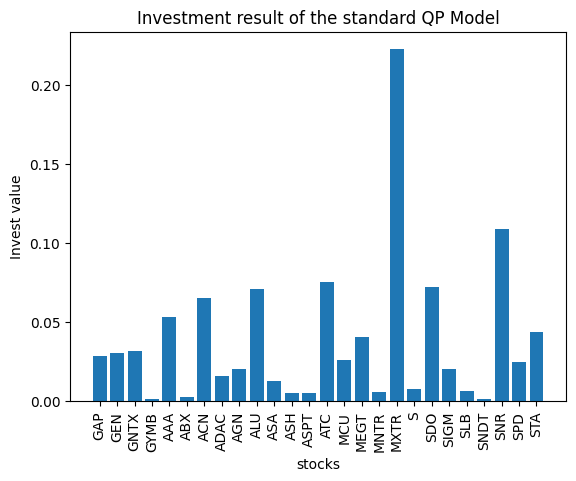

In [4]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
y_pos = np.arange(len(invest['stocks']))
plt.bar(y_pos, invest['level'], align='center', alpha=1)
plt.xticks(y_pos, invest['stocks'],rotation = 90)
plt.xlabel('stocks')
plt.ylabel('Invest value')
plt.title('Investment result of the standard QP Model')
plt.show()